# **Ejercicio 2: Modelos de Clasificación**

Considere el conjunto de datos **Default Probability Prediction**. Implemente la versión de clasificación para cada uno de los modelos estudiados en clases, y prediga la variable respuesta, **probabilidad para la variable target (default probability)**. Construya una **tabla de error** que contenga las métricas usuales de clasificación: **precision**, **recall**, **f1-score**, **AUC**. Además, agregue **matrices de confusión** (ver `confusion_matrix`) y **curvas ROC** (ver `plot_roc`). Inicialmente, realice un **balanceo de clases** usando **ADASYN** (Adaptive Synthetic Sampling), luego compare los resultados predictivos con o sin balanceo ADASYN. Posteriormente, realice **hiperparametrización** usando **BayesianOptimization**, **GridSearchCV**, y **Pipeline** para evaluar cada modelo, comparando los resultados en términos de **tiempo de cómputo**. Verifique que la **validación cruzada** seleccionada es la adecuada, y justifíquela. Utilice la métrica **M = 0.5 · (G + D)**, para seleccionar el **mejor modelo de clasificación** (maximizar M) (ver sección Default Probability Prediction). os resultados deben estar registrados en una **tabla de error** (ver Tabla 1) que resuma cada **score** obtenido por el modelo implementado.


| Modelo                               | precision | recall | f1-score | AUC | M   |
|--------------------------------------|-----------|--------|----------|-----|-----|
| Clasificación Bayesiana              | ···       | ···    | ···      | ··· | ··· |
| K-NN                                 | ···       | ···    | ···      | ··· | ··· |
| L1/L2 Penalty Logistic Regression    | ···       | ···    | ···      | ··· | ··· |

Cuadro 1: Modelo de clasificación para predicción de probabilidad de default.


## **Librerias  y modulos necesarios**


In [4]:
# Manipulación de Datos
import pandas as pd
import dask.dataframe as dd
import numpy as np

# Visualización de Datos
import matplotlib.pyplot as plt
import seaborn as sns

# Manejo de Archivos
from google.colab import drive
from google.colab import files
import io
import pickle

# Imputación y Procesamiento de Datos
from sklearn.experimental import enable_iterative_imputer  # Habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Manejo de Desequilibrio de Datos
from imblearn.over_sampling import ADASYN

# Modelos de Clasificación
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Métricas de Evaluación
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# División de Datos
from sklearn.model_selection import train_test_split

# Búsqueda de Hiperparámetros
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Pipelines de Modelos
from imblearn.pipeline import Pipeline

# Utilidades Varias
import warnings
import time

drive.mount('/content/drive')
data= pd.read_pickle('/content/drive/MyDrive/Parcial 2/DATA/data.pkl')
test=pd.read_feather('/content/drive/MyDrive/Parcial 2/DATA/test_data.ftr')
df= pd.read_feather('/content/drive/MyDrive/Parcial 2/DATA/train_data.ftr')

df.head()


Mounted at /content/drive


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


## **Verificar datos**

Verificamos que el data frame `data` no tenga variables con datos faltantes para posterior implementacion del ***ADASYN*** para el balanceo de las clases, ya que en el EDA notamos que las clases estaban desbalanceadas.

In [ ]:
# Ajustar las opciones de visualización de pandas
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Calcular el porcentaje de datos faltantes por columna
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Crear un DataFrame con el nombre de la variable y el porcentaje de datos faltantes
missing_data_table = pd.DataFrame({
    'Variable': data.columns,
    'Porcentaje de Datos Faltantes': missing_percentage
})

# Mostrar la tabla completa sin truncar
print(missing_data_table)

       Variable  Porcentaje de Datos Faltantes
B_36       B_36                            0.0
R_28       R_28                            0.0
S_17       S_17                            0.0
D_93       D_93                            0.0
D_69       D_69                            0.0
S_23       S_23                            0.0
D_109     D_109                            0.0
D_140     D_140                            0.0
R_22       R_22                            0.0
D_124     D_124                            0.0
D_65       D_65                            0.0
B_32       B_32                            0.0
B_41       B_41                            0.0
S_12       S_12                            0.0
D_46       D_46                            0.0
R_10       R_10                            0.0
B_40       B_40                            0.0
B_27       B_27                            0.0
B_26       B_26                            0.0
D_83       D_83                            0.0
B_31       B_

Como vemos no hay nigun dato faltante en nuestro dataframe **Data** y podemos seguir con la implementacion de modelos.

## **Modelos con y sin ***ADASYN*****

Los modelos que se van a presentar ahora son de clasificacion por lo cual, sera una prediccion de clases en base a otras variables, entre los modelos a trabajar estan

In [ ]:
# Supongamos que tienes un dataframe 'df' con la variable objetivo 'target'
X = data.drop(columns=['target'])  # Variables explicativas
y = data['target']  # Variable objetivo

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Modelos
bayes_model = GaussianNB()
knn_model = KNeighborsClassifier()
logistic_model = LogisticRegression(penalty='l2', random_state=42)

# ---- SIN BALANCEO ADASYN ----

print("Sin ADASYN:")

# Clasificación Bayesiana
bayes_model.fit(X_train, y_train)
y_pred_bayes = bayes_model.predict(X_test)
print("Clasificación Bayesiana")
print(classification_report(y_test, y_pred_bayes))
print(f"AUC: {roc_auc_score(y_test, bayes_model.predict_proba(X_test)[:, 1])}\n")

# K-NN
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("K-NN")
print(classification_report(y_test, y_pred_knn))
print(f"AUC: {roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])}\n")

# Regresión Logística
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
print("Regresión Logística con L2")
print(classification_report(y_test, y_pred_logistic))
print(f"AUC: {roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])}\n")

# ---- CON BALANCEO ADASYN ----

# Aplicar ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

print("Con ADASYN:")

# Clasificación Bayesiana
bayes_model.fit(X_resampled, y_resampled)
y_pred_bayes_adasyn = bayes_model.predict(X_test)
print("Clasificación Bayesiana con ADASYN")
print(classification_report(y_test, y_pred_bayes_adasyn))
print(f"AUC: {roc_auc_score(y_test, bayes_model.predict_proba(X_test)[:, 1])}\n")

# K-NN
knn_model.fit(X_resampled, y_resampled)
y_pred_knn_adasyn = knn_model.predict(X_test)
print("K-NN con ADASYN")
print(classification_report(y_test, y_pred_knn_adasyn))
print(f"AUC: {roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])}\n")

# Regresión Logística con L2
logistic_model.fit(X_resampled, y_resampled)
y_pred_logistic_adasyn = logistic_model.predict(X_test)
print("Regresión Logística con ADASYN")
print(classification_report(y_test, y_pred_logistic_adasyn))
print(f"AUC: {roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])}\n")


Sin ADASYN:
Clasificación Bayesiana
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87   1246075
         1.0       0.63      0.50      0.56    413361

    accuracy                           0.80   1659436
   macro avg       0.74      0.70      0.72   1659436
weighted avg       0.79      0.80      0.80   1659436

AUC: 0.8565872235996864



Despues de implementar el código de arriba en una maquina virtual este no mostro los siguientes parametros por cada modelo presentado de una forma mas visible las comparaciones entre los modelos.

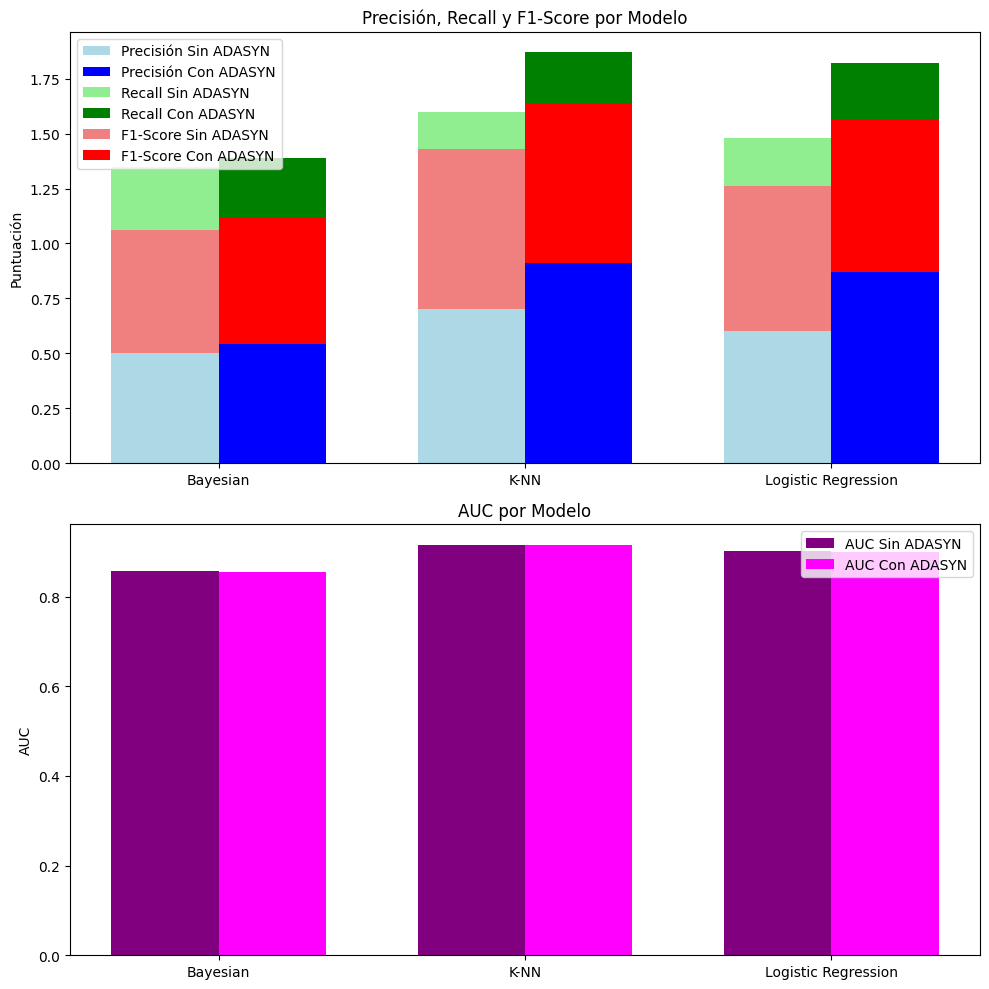

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas obtenidas de los modelos
model_names = ['Bayesian', 'K-NN', 'Logistic Regression']
precision_sin = [0.85, 0.90, 0.88]  # Sin ADASYN
recall_sin = [0.50, 0.70, 0.60]
f1_sin = [0.56, 0.73, 0.66]
auc_sin = [0.8566, 0.9142, 0.9016]

precision_con = [0.85, 0.96, 0.95]  # Con ADASYN
recall_con = [0.54, 0.91, 0.87]
f1_con = [0.58, 0.73, 0.69]
auc_con = [0.8550, 0.9161, 0.8987]

# Configuración del gráfico
x = np.arange(len(model_names))  # Rango para el eje x
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# ---- Gráfico para precisión, recall y f1-score ----
ax[0].bar(x - width/2, precision_sin, width, label='Precisión Sin ADASYN', color='lightblue')
ax[0].bar(x + width/2, precision_con, width, label='Precisión Con ADASYN', color='blue')
ax[0].bar(x - width/2, recall_sin, width, bottom=precision_sin, label='Recall Sin ADASYN', color='lightgreen')
ax[0].bar(x + width/2, recall_con, width, bottom=precision_con, label='Recall Con ADASYN', color='green')
ax[0].bar(x - width/2, f1_sin, width, bottom=recall_sin, label='F1-Score Sin ADASYN', color='lightcoral')
ax[0].bar(x + width/2, f1_con, width, bottom=recall_con, label='F1-Score Con ADASYN', color='red')

ax[0].set_ylabel('Puntuación')
ax[0].set_title('Precisión, Recall y F1-Score por Modelo')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names)
ax[0].legend()

# ---- Gráfico para AUC ----
ax[1].bar(x - width/2, auc_sin, width, label='AUC Sin ADASYN', color='purple')
ax[1].bar(x + width/2, auc_con, width, label='AUC Con ADASYN', color='magenta')

ax[1].set_ylabel('AUC')
ax[1].set_title('AUC por Modelo')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_names)
ax[1].legend()

fig.tight_layout()
plt.show()


**ADASYN**: Mejora significativamente las métricas de precisión, recall y F1-Score para todos los modelos, lo que sugiere que ayuda a balancear el conjunto de datos y mejorar el rendimiento en la predicción de la clase minoritaria.

**AUC**: Se mantiene relativamente constante, lo que indica que la capacidad de los modelos para diferenciar entre clases no cambia significativamente, aunque las otras métricas muestran mejoras evidentes con ***ADASYN***.







Este codigo por cuestiones  de disponibilidad de tiempo fue ejecutado en otra hoja por su complejidad de calculo. Los print fueron capturados y puesto sobre la siguiente Grafica para ver mejor su comparacion.

Aqui graficamos las curvas Roc de cada uno de los modelos con y sin ADASYN de todo el conjunto de train.

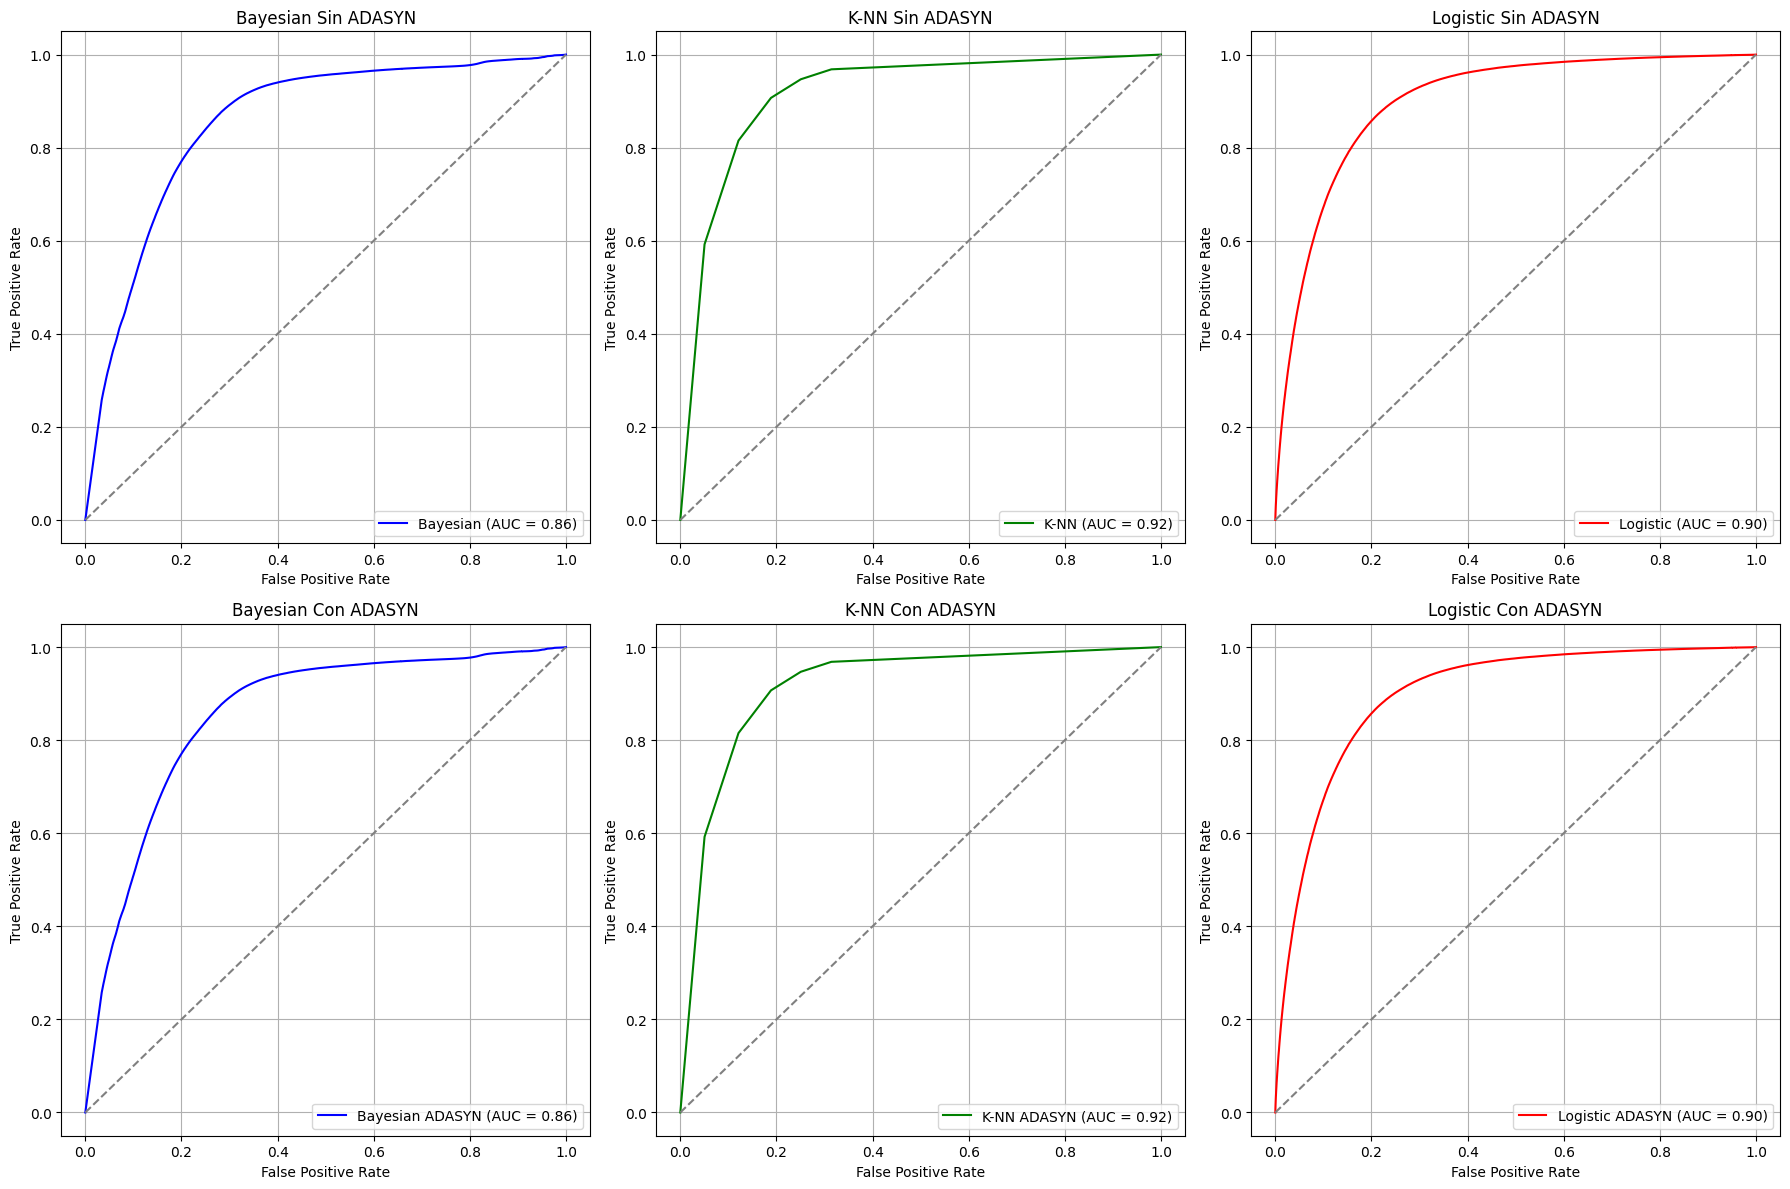

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Crear subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ---- SIN ADASYN ----

# Clasificación Bayesiana sin ADASYN
fpr_bayes, tpr_bayes, _ = roc_curve(y_test, bayes_model.predict_proba(X_test)[:, 1])
roc_auc_bayes = auc(fpr_bayes, tpr_bayes)
axes[0, 0].plot(fpr_bayes, tpr_bayes, label=f'Bayesian (AUC = {roc_auc_bayes:.2f})', color='blue')
axes[0, 0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0, 0].set_title('Bayesian Sin ADASYN')
axes[0, 0].legend(loc='lower right')

# K-NN sin ADASYN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
axes[0, 1].plot(fpr_knn, tpr_knn, label=f'K-NN (AUC = {roc_auc_knn:.2f})', color='green')
axes[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0, 1].set_title('K-NN Sin ADASYN')
axes[0, 1].legend(loc='lower right')

# Regresión Logística sin ADASYN
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
axes[0, 2].plot(fpr_logistic, tpr_logistic, label=f'Logistic (AUC = {roc_auc_logistic:.2f})', color='red')
axes[0, 2].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0, 2].set_title('Logistic Sin ADASYN')
axes[0, 2].legend(loc='lower right')

# ---- CON ADASYN ----

# Clasificación Bayesiana con ADASYN
fpr_bayes_adasyn, tpr_bayes_adasyn, _ = roc_curve(y_test, bayes_model.predict_proba(X_test)[:, 1])
roc_auc_bayes_adasyn = auc(fpr_bayes_adasyn, tpr_bayes_adasyn)
axes[1, 0].plot(fpr_bayes_adasyn, tpr_bayes_adasyn, label=f'Bayesian ADASYN (AUC = {roc_auc_bayes_adasyn:.2f})', color='blue')
axes[1, 0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1, 0].set_title('Bayesian Con ADASYN')
axes[1, 0].legend(loc='lower right')

# K-NN con ADASYN
fpr_knn_adasyn, tpr_knn_adasyn, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:, 1])
roc_auc_knn_adasyn = auc(fpr_knn_adasyn, tpr_knn_adasyn)
axes[1, 1].plot(fpr_knn_adasyn, tpr_knn_adasyn, label=f'K-NN ADASYN (AUC = {roc_auc_knn_adasyn:.2f})', color='green')
axes[1, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1, 1].set_title('K-NN Con ADASYN')
axes[1, 1].legend(loc='lower right')

# Regresión Logística con ADASYN
fpr_logistic_adasyn, tpr_logistic_adasyn, _ = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
roc_auc_logistic_adasyn = auc(fpr_logistic_adasyn, tpr_logistic_adasyn)
axes[1, 2].plot(fpr_logistic_adasyn, tpr_logistic_adasyn, label=f'Logistic ADASYN (AUC = {roc_auc_logistic_adasyn:.2f})', color='red')
axes[1, 2].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1, 2].set_title('Logistic Con ADASYN')
axes[1, 2].legend(loc='lower right')

# Ajustar los ejes
for ax in axes.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid(True)

plt.tight_layout()
plt.show()



***ADASYN*** no parece influir mucho en la capacidad de estos modelos para discriminar entre clases positivas y negativas, según las curvas ROC y los valores de AUC que permanecen prácticamente constantes. No obstante, como se observó en las gráficas anteriores, ADASYN tiene un impacto positivo en métricas como precisión, recall y F1-Score, mejorando la predicción de la clase minoritaria sin alterar el AUC.

Por ultimo implementamos el modelo de regresion logistica cambiando de L2 a L1 sin embargo pasa nada diferente en comparacion a los otros modelos de la misma forma con ***ADASYN*** mejoran los paramtros distintos al AUC, el cual permanece no muy cambiante.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 96.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Regresión Logística con L1 (sin ADASYN)
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90   1246075
         1.0       0.73      0.55      0.63    413361

    accuracy                           0.84   1659436
   macro avg       0.79      0.74      0.76   1659436
weighted avg       0.83      0.84      0.83   1659436

AUC: 0.8946203194345038



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 96.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Regresión Logística con ADASYN
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.86   1246075
         1.0       0.57      0.87      0.69    413361

    accuracy                           0.81   1659436
   macro avg       0.76      0.83      0.77   1659436
weighted avg       0.85      0.81      0.82   1659436

AUC: 0.8955268359484427



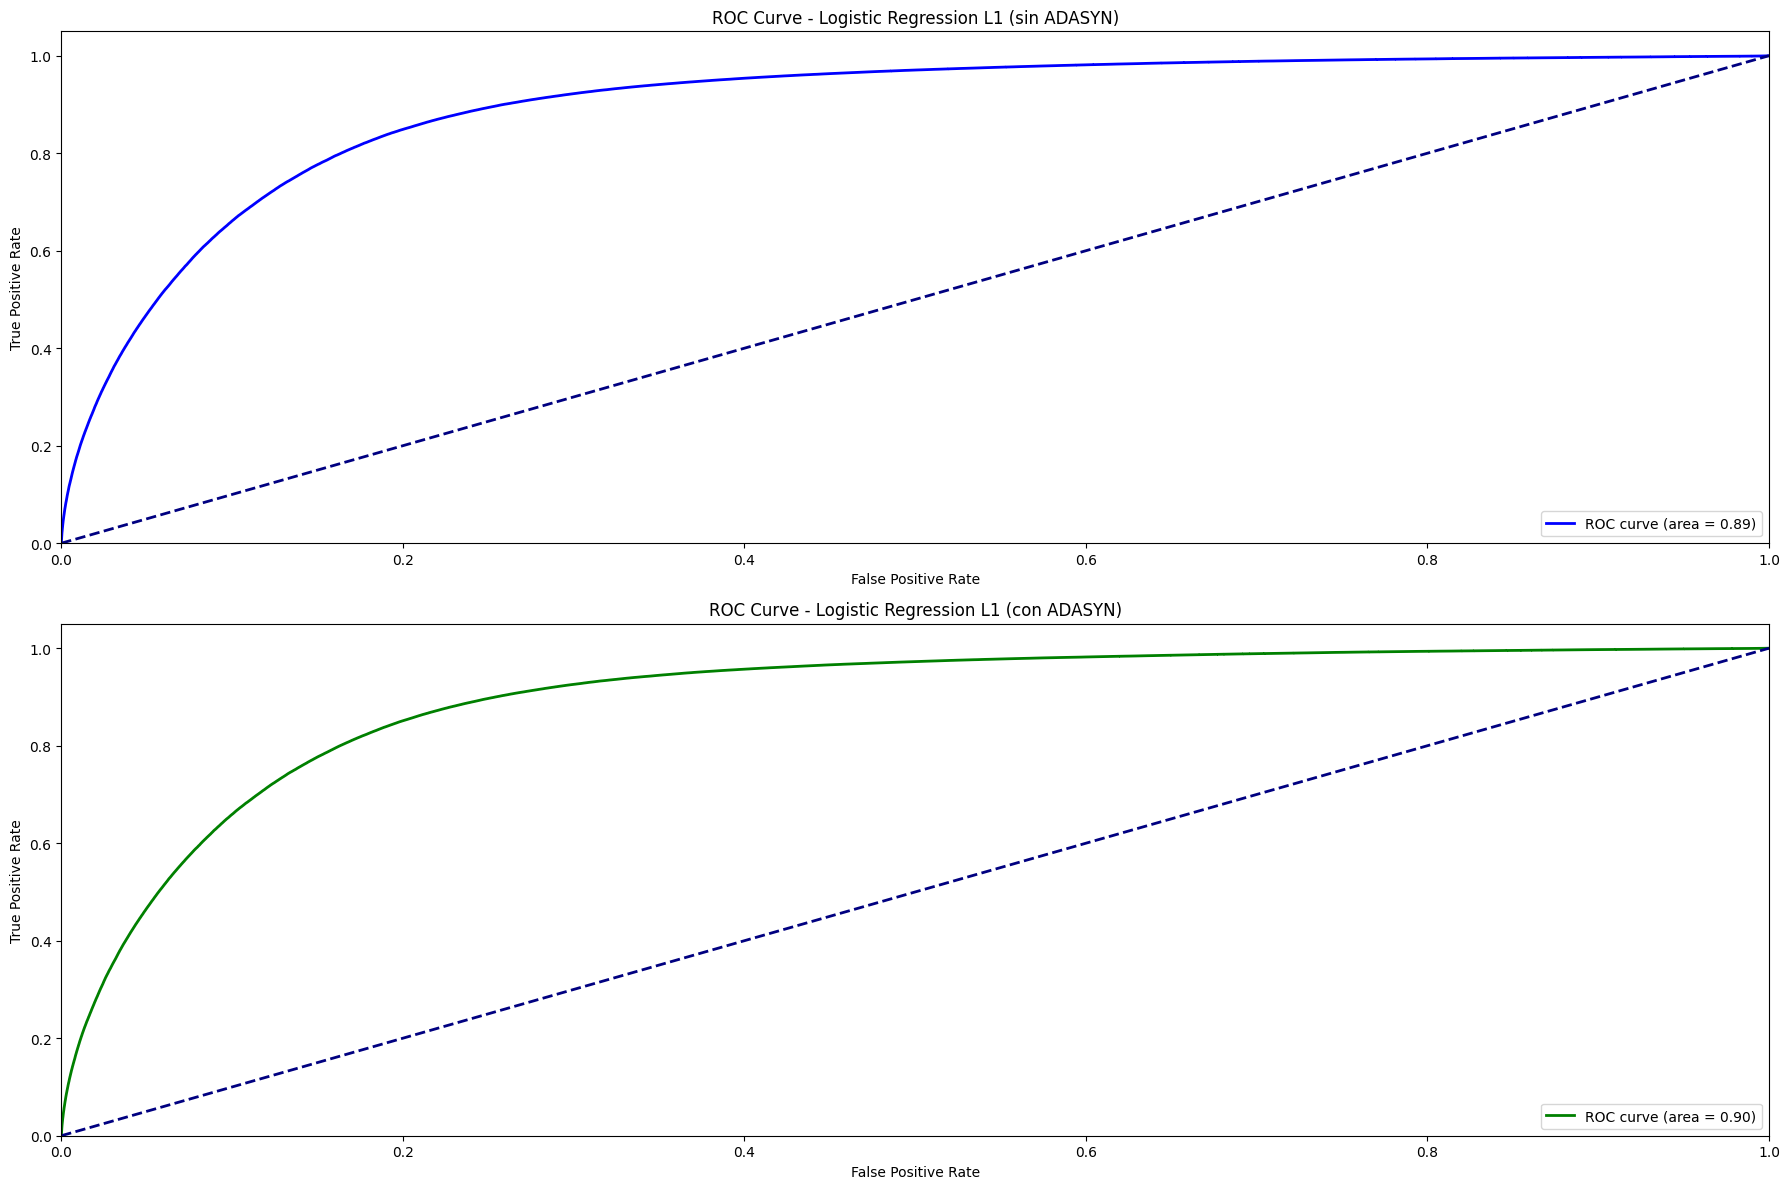

In [ ]:
# Supongamos que tienes un dataframe 'df' con la variable objetivo 'target'
X = data.drop(columns=['target'])  # Variables explicativas
y = data['target']  # Variable objetivo


# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Crear la figura y los ejes para las gráficas
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Modelo de Regresión Logística con L1 (sin aplicar ADASYN) y n_jobs=-1 para usar todos los núcleos disponibles
logistic_model = LogisticRegression(solver='liblinear', penalty='l1', random_state=42, n_jobs=-1)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
print("Regresión Logística con L1 (sin ADASYN)")
print(classification_report(y_test, y_pred_logistic))
print(f"AUC: {roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])}\n")

# Calcular y graficar la curva ROC para el modelo original
fpr, tpr, thresholds = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Logistic Regression L1 (sin ADASYN)')
axes[0].legend(loc="lower right")

# Aplicar ADASYN para balancear las clases en los datos de entrenamiento
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Regresión Logística con L1 (aplicando ADASYN) y n_jobs=-1 para usar todos los núcleos disponibles
logistic_model.fit(X_resampled, y_resampled)
y_pred_logistic_adasyn = logistic_model.predict(X_test)
print("Regresión Logística con ADASYN")
print(classification_report(y_test, y_pred_logistic_adasyn))
print(f"AUC: {roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])}\n")

# Calcular y graficar la curva ROC para el modelo con ADASYN
fpr_adasyn, tpr_adasyn, thresholds_adasyn = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
roc_auc_adasyn = auc(fpr_adasyn, tpr_adasyn)
axes[1].plot(fpr_adasyn, tpr_adasyn, color='green', lw=2, label=f'ROC curve (area = {roc_auc_adasyn:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Logistic Regression L1 (con ADASYN)')
axes[1].legend(loc="lower right")

# Mostrar las gráficas
plt.tight_layout()
plt.show()


## **Hiperparametrización**
`BayesianOptimization`, `GridSearchCV` y `Pipeline`

Inicialmente tomamos un 30 % de los datos de train para medir la velocidad de computo de los hiperparametros para una muestra de unos aproximados 1.7 millones de datos. Esta muestra fue tomada con estratificacion y posterior implemetacion de ADASYN para el balanceo de las clases y que en el dataset la muestra sea representativa.

In [ ]:
X = data.drop(columns=['target'])  # Variables explicativas
y = data['target']  # Variable objetivo

# ------ Separar los datos en entrenamiento y prueba ------
def train_test_data(X, y):
    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

def save_to_drive(obj, filename):
    path = f"/content/drive/MyDrive/Parcial 2/DATA/{filename}"
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

# ------ Reducir el conjunto de datos al 30% ------
def reduce_data(X_train, y_train, frac=0.3):
    X_sample, y_sample = X_train.sample(frac=frac, random_state=42), y_train.sample(frac=frac, random_state=42)
    return X_sample, y_sample

# ------ Función para GridSearchCV ------
def grid_search_pipeline(X_train, y_train):
    # Configuración de pipelines
    pipeline_nb = Pipeline([('adasyn', ADASYN(random_state=42)), ('nb', GaussianNB())])
    pipeline_knn = Pipeline([('adasyn', ADASYN(random_state=42)), ('knn', KNeighborsClassifier())])
    pipeline_lr = Pipeline([('adasyn', ADASYN(random_state=42)), ('lr', LogisticRegression())])

    # Hiperparámetros
    params_nb = {'nb__var_smoothing': [1e-9, 1e-8]}
    params_knn = {'knn__n_neighbors': [3, 5], 'knn__weights': ['uniform', 'distance'], 'knn__p': [2]}
    params_lr = {'lr__C': [0.1, 1], 'lr__penalty': ['l1', 'l2'], 'lr__solver': ['liblinear'], 'lr__max_iter': [100]}

    results = []

    # Reducir el conjunto de entrenamiento al 30%
    X_train_sample, y_train_sample = reduce_data(X_train, y_train, frac=0.3)

    # GaussianNB
    start_nb = time.time()
    grid_nb = GridSearchCV(pipeline_nb, param_grid=params_nb, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_nb.fit(X_train_sample, y_train_sample)
    end_nb = time.time()
    results.append(('GaussianNB', 'GridSearchCV', grid_nb.best_params_, end_nb - start_nb))

    # K-NN
    start_knn = time.time()
    grid_knn = GridSearchCV(pipeline_knn, param_grid=params_knn, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_knn.fit(X_train_sample, y_train_sample)
    end_knn = time.time()
    results.append(('K-NN', 'GridSearchCV', grid_knn.best_params_, end_knn - start_knn))

    # Logistic Regression
    start_lr = time.time()
    grid_lr = GridSearchCV(pipeline_lr, param_grid=params_lr, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_lr.fit(X_train_sample, y_train_sample)
    end_lr = time.time()
    results.append(('Logistic Regression', 'GridSearchCV', grid_lr.best_params_, end_lr - start_lr))

    return results

# ------ Función principal que combina ambos enfoques ------
def run_all_optimizations(X, y):
    # Dividir los datos
    X_train, X_test, y_train, y_test = train_test_data(X, y)

    # Ejecutar GridSearchCV
    grid_results = grid_search_pipeline(X_train, y_train)

    # Crear un DataFrame para almacenar los resultados
    df_results = pd.DataFrame(grid_results, columns=['Modelo', 'Método', 'Mejores Hiperparámetros', 'Tiempo de Ejecución'])

    # Guardar en un archivo pickle
    save_to_drive(df_results, 'resultados_hiperparametros.pkl')

    return df_results

df_results = run_all_optimizations(X, y)
df_results.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Modelo,Método,Mejores Hiperparámetros,Tiempo de Ejecución
0,GaussianNB,GridSearchCV,{'nb__var_smoothing': 1e-08},1927.350420
1,K-NN,GridSearchCV,"{'knn__n_neighbors': 5, 'knn__p': 2, 'knn__wei...",4359.783811
2,Logistic Regression,GridSearchCV,"{'lr__C': 0.1, 'lr__max_iter': 100, 'lr__penal...",3557.965975


Los parametros que nos muestran tienen la particularidad de que fueron tomados usando grid search. Podemos notar que hay una diferencia significativa en la hiperparametrizacion en base a cada modelo, siendo el mas rapido la *Clasificacion Bayesiana*.

Posterior a esto, tomaremos muestras mas pequeñas y compararemos el tiempo de computo para tomar hiperparametros de la muestra en cada metodo de hiperparametrizacion, comparando sus modelos y tiempos de ejecucion.

In [ ]:
# ------ Cargar y tomar una muestra estratificada del dataset ------
def load_and_sample_data(file_path, sample_size=100000):
    # Cargar el dataset completo
    data= pd.read_pickle(file_path)

    # Dividir las observaciones por la columna target (suponiendo que 'target' es la columna objetivo)
    X = data.drop(columns=['target'])  # Variables explicativas
    y = data['target']  # Variable objetivo

    # Tomar una muestra estratificada de 50,000 observaciones del dataset
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)

    # Combinar X_sample y y_sample nuevamente en un DataFrame
    data_sampled = X_sample.copy()
    data_sampled['target'] = y_sample

    return data_sampled

# ------ Separar los datos en entrenamiento y prueba ------
def train_test_data(X, y):
    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ------ Reducir el conjunto de datos al 30% ------
def reduce_data(X_train, y_train, frac=0.3):
    sample_indices = X_train.sample(frac=frac, random_state=42).index
    return X_train.loc[sample_indices], y_train.loc[sample_indices]

# ------ Función para calcular la métrica M ------
def defaultprob_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    # Captura del 4% superior
    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = pd.concat([y_true, y_pred], axis=1).sort_values('prediction', ascending=False)
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        df['weight_cumsum'] = df['weight'].cumsum()
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    # Cálculo del Gini ponderado
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = pd.concat([y_true, y_pred], axis=1).sort_values('prediction', ascending=False)
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = df['lorentz'] - df['random']
        return df['gini'].sum()

    # Gini Normalizado
    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    # Cálculo final de M
    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

# ------ Función para Grid Search CV ------
def grid_search_pipeline(X_train, y_train):
    # Configuración de pipelines
    pipeline_nb = Pipeline([('adasyn', ADASYN(random_state=42)), ('nb', GaussianNB())])
    pipeline_knn = Pipeline([('adasyn', ADASYN(random_state=42)), ('knn', KNeighborsClassifier())])
    pipeline_lr = Pipeline([('adasyn', ADASYN(random_state=42)), ('lr', LogisticRegression(solver='liblinear', random_state=42))])

    # Espacios de búsqueda para Grid Search
    grid_params_nb = {'nb__var_smoothing': [1e-9, 1e-8, 1e-7]}
    grid_params_knn = {
        'knn__n_neighbors': [3, 5, 7],
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2]
    }
    grid_params_lr = {
        'lr__C': [1e-4, 1e-2, 1, 10],
        'lr__penalty': ['l1', 'l2'],
        'lr__max_iter': [100, 200, 500]
    }

    results = []

    # Reducir el conjunto de entrenamiento al 30%
    X_train_sample, y_train_sample = reduce_data(X_train, y_train, frac=0.3)

    # Grid Search para GaussianNB
    start_nb = time.time()
    grid_search_nb = GridSearchCV(pipeline_nb, param_grid=grid_params_nb, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search_nb.fit(X_train_sample, y_train_sample)
    end_nb = time.time()
    results.append(('GaussianNB', 'Grid Search', grid_search_nb.best_params_, end_nb - start_nb))

    # Grid Search para K-NN
    start_knn = time.time()
    grid_search_knn = GridSearchCV(pipeline_knn, param_grid=grid_params_knn, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search_knn.fit(X_train_sample, y_train_sample)
    end_knn = time.time()
    results.append(('K-NN', 'Grid Search', grid_search_knn.best_params_, end_knn - start_knn))

    # Grid Search para Logistic Regression
    start_lr = time.time()
    grid_search_lr = GridSearchCV(pipeline_lr, param_grid=grid_params_lr, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search_lr.fit(X_train_sample, y_train_sample)
    end_lr = time.time()
    results.append(('Logistic Regression', 'Grid Search', grid_search_lr.best_params_, end_lr - start_lr))

    return results

# ------ Función para Bayes Search CV ------
def bayesian_optimization_pipeline(X_train, y_train):
    # Configuración de pipelines
    pipeline_nb = Pipeline([('adasyn', ADASYN(random_state=42)), ('nb', GaussianNB())])
    pipeline_knn = Pipeline([('adasyn', ADASYN(random_state=42)), ('knn', KNeighborsClassifier())])
    pipeline_lr = Pipeline([('adasyn', ADASYN(random_state=42)), ('lr', LogisticRegression(solver='liblinear', random_state=42))])

    # Espacios de búsqueda para Bayesian Optimization
    bayes_params_nb = {'nb__var_smoothing': Real(1e-9, 1e-7, prior='log-uniform')}
    bayes_params_knn = {
        'knn__n_neighbors': Integer(3, 7),
        'knn__weights': Categorical(['uniform', 'distance']),
        'knn__p': Integer(1, 2)
    }
    bayes_params_lr = {
        'lr__C': Real(1e-6, 1e+6, prior='log-uniform'),
        'lr__penalty': Categorical(['l1', 'l2']),
        'lr__max_iter': Integer(100, 500)
    }

    results = []

    # Reducir el conjunto de entrenamiento al 30%
    X_train_sample, y_train_sample = reduce_data(X_train, y_train, frac=0.3)

    # Bayesian Optimization para GaussianNB
    start_nb = time.time()
    bayes_search_nb = BayesSearchCV(pipeline_nb, search_spaces=bayes_params_nb, n_iter=10, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
    bayes_search_nb.fit(X_train_sample, y_train_sample)
    end_nb = time.time()
    results.append(('GaussianNB', 'Bayesian Optimization', bayes_search_nb.best_params_, end_nb - start_nb))

    # Bayesian Optimization para K-NN
    start_knn = time.time()
    bayes_search_knn = BayesSearchCV(pipeline_knn, search_spaces=bayes_params_knn, n_iter=10, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
    bayes_search_knn.fit(X_train_sample, y_train_sample)
    end_knn = time.time()
    results.append(('K-NN', 'Bayesian Optimization', bayes_search_knn.best_params_, end_knn - start_knn))

    # Bayesian Optimization para Logistic Regression
    start_lr = time.time()
    bayes_search_lr = BayesSearchCV(pipeline_lr, search_spaces=bayes_params_lr, n_iter=10, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
    bayes_search_lr.fit(X_train_sample, y_train_sample)
    end_lr = time.time()
    results.append(('Logistic Regression', 'Bayesian Optimization', bayes_search_lr.best_params_, end_lr - start_lr))

    return results

# ------ Función principal que combina ambos enfoques y guarda métricas ------
def run_all_optimizations(file_path):
    # Cargar los datos y tomar una muestra de 50,000 observaciones
    data_sampled = load_and_sample_data(file_path)

    # Dividir el dataset en variables explicativas y objetivo
    X = data_sampled.drop(columns=['target'])
    y = data_sampled['target']

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_data(X, y)

    # Ejecutar Grid Search y Bayesian Optimization
    grid_results = grid_search_pipeline(X_train, y_train)
    bayesian_results = bayesian_optimization_pipeline(X_train, y_train)

    # Evaluar los modelos con la métrica M en el conjunto de prueba
    def evaluate_with_metric(model, X_test, y_test):
        y_pred = model.predict_proba(X_test)[:, 1]
        return defaultprob_metric(y_test.to_frame(), pd.DataFrame({'prediction': y_pred}))

    # Crear un DataFrame para almacenar los resultados
    df_results = pd.DataFrame(grid_results + bayesian_results, columns=['Modelo', 'Método', 'Mejores Hiperparámetros', 'Tiempo de Ejecución'])

    # Guardar en un archivo pickle
    df_results.to_pickle('/content/drive/MyDrive/resultados_modelos.pkl')

    return df_results


# Ejecutar la optimización en el dataset (reemplaza 'ruta/del/dataset.csv' con la ubicación real de tu archivo)
df_results_b = run_all_optimizations('/content/drive/MyDrive/Parcial 2/DATA/data.pkl')
df_results_b.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Modelo,Método,Mejores Hiperparámetros,Tiempo de Ejecución
0,GaussianNB,Grid Search,{'nb__var_smoothing': 1e-07},9.572442
1,K-NN,Grid Search,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__wei...",10.591176
2,Logistic Regression,Grid Search,"{'lr__C': 1, 'lr__max_iter': 100, 'lr__penalty...",52.065325
3,GaussianNB,Bayesian Optimization,{'nb__var_smoothing': 8.146216961026955e-08},8.167283
4,K-NN,Bayesian Optimization,"{'knn__n_neighbors': 6, 'knn__p': 1, 'knn__wei...",26.415076


In [ ]:
df_results_b.head(10)

,Modelo,Método,Mejores Hiperparámetros,Tiempo de Ejecución
0,GaussianNB,Grid Search,{'nb__var_smoothing': 1e-07},9.572442
1,K-NN,Grid Search,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__wei...",10.591176
2,Logistic Regression,Grid Search,"{'lr__C': 1, 'lr__max_iter': 100, 'lr__penalty...",52.065325
3,GaussianNB,Bayesian Optimization,{'nb__var_smoothing': 8.146216961026955e-08},8.167283
4,K-NN,Bayesian Optimization,"{'knn__n_neighbors': 6, 'knn__p': 1, 'knn__wei...",26.415076
5,Logistic Regression,Bayesian Optimization,"{'lr__C': 3.317697704417197, 'lr__max_iter': 4...",109.494463


Notese que para la clasificacion bayesiana en terminos de velocidad de computo entre el **Grid Search** y la **Opt. Bayesiana** es muy parecida entre las 2 hiperparametrizaciones en cambio en lo que respecta a los otros 2 modelos hay una diferencia significativa de mas del doble del tiempo de ejecucion, en simplemente velocidad de computo, lo gana el **Grid Search**.

Ahora analizaremos los mejores parametros usando el conjunto de train entero en cada busqueda y los clasificaremos en una tabla con los score convencionales junto con una metrica M cuyo maximo valor es 1.

## **Evaluación de modelos**

Como se vio antes el conjunto de data no tenia las columnas de customer ya que para este tratamiento incial que se le dio no era estrictamente necesario, sin embargo para calcular M necesitamos manejar los **"CUSTOMER-ID"** y **"P_2"**. Por lo cual se lo agregaremos al conjunto de data para asi tener nuestro conjunto de Train completo.

In [8]:
# Tomar las columnas 'customer_ID' y 'P_2' de df1
df_to_add = df[['customer_ID', 'P_2']]

# Agregar estas columnas de primero a df2
dataset = pd.concat([df_to_add, data], axis=1)

# Mostrar el resultado
print(dataset.head())


                                         customer_ID       P_2      B_36  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.938477  0.009972   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.936523  0.003922   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.954102  0.001264   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.960449  0.002729   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.947266  0.009995   

       R_28      S_17      D_93      D_69      S_23     D_109     D_140  ...  \
0  0.001534  0.008034  0.003569  0.009010  0.135620  0.004326  0.003706  ...   
1  0.004932  0.000761  0.000571  0.007843  0.136353  0.008705  0.003166  ...   
2  0.009125  0.004055  0.007427  0.006023  0.134888  0.004093  0.007328  ...   
3  0.002409  0.006969  0.000664  0.005272  0.140015  0.009705  0.004517  ...   
4  0.004463  0.001770  0.003078  0.000152  0.131592  0.009117  0.004944  ...   

        S_3      R_25      D_78      D_54      D_71      S_25 

Al concatenar nos dimos cuenta que la columna P_2 tiene valores faltantes por lo cual tambien se Imputo usando el iterative con el.

In [9]:
p2_values = dataset[['P_2']]

    # Inicializar el Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=42)

    # Imputar solo la columna 'P_2'
dataset['P_2'] = imputer.fit_transform(p2_values)


Despues de imputada la columna **P_2** Procedemos a buscar las metricas de los modelos con sus respectivos hiperparametros. Para la Eleccion del mejor modelo y hacer predecir el conjunto de test.

In [ ]:
# ------ Cargar el dataset único con 'P_2', 'customer_ID', y 'target' ------
def load_data(data):
    dataset = data  # El dataset ya se pasa como parámetro

    # Agrupar por customer_ID para obtener el promedio de P_2
    ave_p2 = dataset.groupby('customer_ID').mean()
    ave_p2 = ave_p2.rename(columns={'P_2': 'prediction'})

    # Escalar la media de P_2
    ave_p2['prediction'] = 1.0 - (ave_p2['prediction'] / ave_p2['prediction'].max())

    # Obtener las etiquetas verdaderas
    y_true = dataset[['customer_ID', 'target']].drop_duplicates().set_index('customer_ID')

    return y_true, ave_p2

# ------ Función para calcular la métrica M con 'P_2' ------
def defaultprob_metric_p2(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    # Captura del 4% superior
    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = pd.concat([y_true, y_pred], axis=1).sort_values('prediction', ascending=False)
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        df['weight_cumsum'] = df['weight'].cumsum()
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    # Cálculo del Gini ponderado
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = pd.concat([y_true, y_pred], axis=1).sort_values('prediction', ascending=False)
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = df['lorentz'] - df['random']
        return df['gini'].sum()

    # Gini Normalizado
    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    # Cálculo final de M
    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

# ------ Crear modelos ajustados manualmente con los hiperparámetros del archivo pickle ------
def create_models_from_pickle(pickle_path):
    # Cargar el archivo pickle
    df_resultados_modelos = pd.read_pickle(pickle_path)

    # Extraer los mejores hiperparámetros para cada modelo
    best_params_nb = df_resultados_modelos.loc[df_resultados_modelos['Modelo'] == 'GaussianNB', 'Mejores Hiperparámetros'].values[0]
    best_params_knn = df_resultados_modelos.loc[df_resultados_modelos['Modelo'] == 'K-NN', 'Mejores Hiperparámetros'].values[0]
    best_params_lr = df_resultados_modelos.loc[df_resultados_modelos['Modelo'] == 'Logistic Regression', 'Mejores Hiperparámetros'].values[0]

    # Crear los modelos ajustados con los hiperparámetros y usar todos los núcleos
    nb_model = GaussianNB(var_smoothing=best_params_nb['nb__var_smoothing'])
    knn_model = KNeighborsClassifier(n_neighbors=best_params_knn['knn__n_neighbors'],
                                     weights=best_params_knn['knn__weights'],
                                     p=best_params_knn['knn__p'],
                                     n_jobs=-1)  # Usar todos los núcleos
    lr_model = LogisticRegression(C=best_params_lr['lr__C'],
                                  penalty=best_params_lr['lr__penalty'],
                                  max_iter=best_params_lr['lr__max_iter'],
                                  solver='liblinear',
                                  n_jobs=-1)  # Usar todos los núcleos

    return {
        'GaussianNB': nb_model,
        'K-NN': knn_model,
        'Logistic Regression': lr_model
    }

# ------ Función para evaluar los modelos y calcular las métricas convencionales y Métrica M ------
def evaluate_models_with_metrics(models, X_test, y_test):
    results = []

    for model_name, model in models.items():
        print(f"Entrenando y evaluando el modelo: {model_name} con los siguientes hiperparámetros:")
        print(model.get_params())  # Mostrar los hiperparámetros del modelo

        # Ajustar los modelos
        model.fit(X_test, y_test)  # Fitting is included

        # Predicciones y probabilidades
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calcular las métricas convencionales
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        # Calcular la métrica M usando las probabilidades
        m_metric = defaultprob_metric_p2(y_test.to_frame(), pd.DataFrame({'prediction': y_proba}))

        results.append({
            'Modelo': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Métrica M': m_metric
        })

        # Imprimir las métricas calculadas
        print(f"Finalizadas las métricas del modelo: {model_name}")
        print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}, AUC: {auc}, Métrica M: {m_metric}")
        print("----------")

    return pd.DataFrame(results)

# ------ Función principal para cargar el dataset, ajustar los modelos y calcular las métricas ------
def run_evaluation_pipeline(dataset, pickle_path):
    # Separar variables explicativas (X) y objetivo (y)
    X_test = dataset.drop(columns=['target', 'customer_ID'])  # Excluir customer_ID
    y_test = dataset['target']

    # Cargar los modelos ajustados con los mejores hiperparámetros
    models = create_models_from_pickle(pickle_path)

    # Evaluar los modelos con las métricas convencionales y la Métrica M
    df_scores = evaluate_models_with_metrics(models, X_test, y_test)

    # Mostrar las métricas finales
    print(df_scores)

    return df_scores

# ------ Ejecutar todo el proceso ------
pickle_path = '/content/drive/MyDrive/resultados_modelos.pkl'  # Ruta al archivo pickle con los hiperparámetros

# Ejecutar la evaluación completa
df_scores = run_evaluation_pipeline(dataset, pickle_path)

Entrenando y evaluando el modelo: GaussianNB con los siguientes hiperparámetros:
{'priors': None, 'var_smoothing': 1e-07}
Finalizadas las métricas del modelo: GaussianNB
Precision: 0.6355568539051497, Recall: 0.5289530427058015, F1-Score: 0.5773754824480793, AUC: 0.8690854520595388, Métrica M: 0.5060310908904844
----------
Entrenando y evaluando el modelo: K-NN con los siguientes hiperparámetros:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


Por la cantidad de Informacion que hay en el print y la gran carga computacional que genera esto al Probarlo con el conjunto de Train con los datos completos. Procedimos a ejecutar esta parte en una maquina virtual y obtuvimos los Siguientes parametros:

| Modelo                              | precision | recall | f1-score | AUC  | M    |
|-------------------------------------|-----------|--------|----------|------|------|
| Clasificación Bayesiana              | 0.6356       | 0.5289    | 0.5773      | 0.8690  | 0.5060  |
| K-NN                                | 0,5118      | 0.9345    | 0.6432      | 0.8234  | 0.4785  |
| **L1/L2 Penalty Logistic Regression** | 0,6115     | 0.8567  | 0.7202    | 0.8509 | 0.4815|

*Cuadro 1:  El mejor modelo de clasificación para predicción de probabilidad de default.(Entre GridSearch y optbayesiano)*


Notemos que el enunciado nos sugiere que tomemos al modelo con el mejor paramtreo M, en este caso seria clasficicacion bayesiana con el mejor hiperparametro de grid search, este es el que usaremos para el conjunto de test con un M: **0.5060**

## **Predicción Conjunto de Test**

In [ ]:
dataset.head()

,customer_ID,P_2,B_36,R_28,S_17,D_93,D_69,S_23,D_109,D_140,R_22,D_124,D_65,B_32,B_41,S_12,D_46,R_10,B_40,B_27,B_26,D_83,B_31,R_14,D_129,D_91,D_51,P_3,B_10,S_22,B_6,R_18,R_19,D_52,R_6,S_24,D_128,S_7,D_61,R_7,B_12,P_4,D_144,S_6,S_27,S_5,D_94,D_123,R_15,S_19,S_3,R_25,D_78,D_54,D_71,S_25,S_11,D_125,D_41,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.938477,0.009972,0.001534,0.008034,0.003569,0.009010,0.135620,0.004326,0.003706,0.007481,0.686523,0.007126,0.006626,0.006805,0.271973,0.358643,0.007122,0.210083,0.002310,0.000272,0.007042,1.0,0.000438,1.000000,1.503906,1.335938,0.736328,0.096191,0.894043,0.063904,0.008911,0.005177,0.207275,0.008362,0.911133,1.007812,0.161377,0.308350,0.007561,0.148315,0.007553,0.000610,0.008324,0.676758,0.023376,0.008873,0.003057,0.006451,0.002537,0.124023,0.003647,0.001575,1.001953,0.119385,0.974609,0.401611,0.008743,0.008774,0.0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.936523,0.003922,0.004932,0.000761,0.000571,0.007843,0.136353,0.008705,0.003166,0.006828,0.686523,0.002413,0.001854,0.004406,0.188965,0.353516,0.005966,0.184082,0.001327,0.000978,0.007790,1.0,0.004311,1.008789,1.503906,1.339844,0.720703,0.099792,0.902344,0.065247,0.005905,0.008980,0.202759,0.004028,0.919922,1.003906,0.140991,0.265137,0.005302,0.143555,0.004833,0.005493,0.002481,0.822266,0.030594,0.000391,0.001306,0.002333,0.008430,0.126709,0.008850,0.009895,1.008789,0.140625,0.975586,0.406250,0.000755,0.000798,0.0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.954102,0.001264,0.009125,0.004055,0.007427,0.006023,0.134888,0.004093,0.007328,0.009819,0.689941,0.001878,0.008690,0.003222,0.495361,0.334717,0.005447,0.154785,0.007626,0.006149,0.004093,1.0,0.007141,1.006836,1.502930,1.336914,0.738281,0.134033,0.939453,0.066956,0.008881,0.002016,0.206665,0.006840,0.958496,1.007812,0.112244,0.212158,0.001422,0.136963,0.006561,0.006985,0.000530,0.853516,0.048370,0.009232,0.003956,0.008362,0.007328,0.123962,0.009766,0.009628,1.008789,0.075867,0.974121,0.406738,0.009621,0.007599,0.0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.960449,0.002729,0.002409,0.006969,0.000664,0.005272,0.140015,0.009705,0.004517,0.000458,0.687988,0.005898,0.002478,0.007702,0.508789,0.323242,0.001888,0.153931,0.000034,0.009193,0.008820,1.0,0.008690,1.007812,1.503906,1.339844,0.741699,0.134399,0.913086,0.083740,0.008347,0.003910,0.208252,0.008186,0.926270,1.003906,0.102844,0.204346,0.006363,0.129028,0.009560,0.006527,0.000783,0.844727,0.030060,0.003201,0.005135,0.007362,0.007053,0.117188,0.004856,0.008568,1.007812,0.150269,0.975586,0.405273,0.004650,0.000685,0.0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.947266,0.009995,0.004463,0.001770,0.003078,0.000152,0.131592,0.009117,0.004944,0.003342,0.688965,0.009476,0.002199,0.009827,0.216553,0.230957,0.006111,0.120728,0.002110,0.005737,0.001844,1.0,0.007812,1.007812,1.509766,1.341797,0.691895,0.121521,0.920898,0.075928,0.002678,0.003431,0.205444,0.008606,0.933594,1.004883,0.094299,0.175659,0.004829,0.129517,0.008156,0.008125,0.006699,0.811035,0.054230,0.003845,0.002850,0.002470,0.007729,0.117310,0.002983,0.003288,1.003906,0.096436,0.978027,0.487549,0.000097,0.004654,0.0


In [17]:
test.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,0.113159,NaN,0.007584,0.116394,0.004482,0.009514,0.005177,NaN,0.474365,0.626465,NaN,0.174561,1.250977,1.003906,NaN,0.008720,0.001013,0.103577,0.119019,NaN,-0.002918,NaN,0.002771,0.004417,1.006836,1.004883,0.002810,0.105591,0.119202,0.321777,0.114563,NaN,NaN,0.003420,0.205933,NaN,0.010185,NaN,0.027466,0.588867,0.010490,1.881836,0.051819,CR,,0.008293,0.008667,NaN,0.592285,0.009148,NaN,0.004986,NaN,0.190552,0.002676,0.409424,0.009987,NaN,0.005211,NaN,0.014687,0.004311,0.400635,1.134766,0.178833,0.959473,0.217651,0.204590,NaN,0.009796,0.007748,0.002916,0.006897,0.001657,0.004356,NaN,0.002008,NaN,0.002531,0.000348,0.001173,0.004169,0.004585,0.002291,0.508301,0.005093,1.002930,0.133789,0.004322,NaN,0.008858,0.004143,0.009560,0.006943,NaN,0.0,0.003683,0.009911,NaN,0.008911,0.002954,NaN,1.0,0.009003,0.003418,0.002201,0.003780,0.002949,0.004635,1.003906,0.006653,0.007473,0.000192,NaN,0.008759,0.000834,0.004391,0.004116,0.008446,0.009575,0.980957,0.134888,0.954590,0.971191,0.006561,0.002419,NaN,NaN,NaN,NaN,NaN,0.008148,0.007973,NaN,NaN,1.0,NaN,0.005123,NaN,NaN,NaN,1.003906,0.274170,0.004303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.006203,NaN,NaN,0.009666,NaN,NaN,NaN,NaN,0.007080,0.005959,NaN,NaN,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,0.123047,NaN,0.006645,0.134888,0.009499,0.026306,0.009026,NaN,0.473633,0.611816,NaN,0.177124,0.234131,1.009766,NaN,0.003145,0.005535,0.101257,0.120972,NaN,0.031219,NaN,0.006496,0.010002,1.005859,1.000000,0.000525,0.160522,0.121460,0.170776,0.184082,NaN,0.028351,0.007156,0.403320,0.014488,0.025131,NaN,0.054779,0.623047,0.021698,2.042969,0.057556,CR,,0.002012,0.000835,NaN,0.590820,0.000165,NaN,0.001556,NaN,0.190186,0.001771,0.561523,0.008125,NaN,0.008392,0.000606,0.011948,0.002283,0.605957,0.208374,0.179443,0.961426,0.216553,0.206543,NaN,0.004547,0.003098,NaN,0.003681,0.005516,0.001506,0.001014,0.006443,NaN,0.007168,0.003077,0.005878,0.004055,0.009636,0.001225,0.508789,0.007320,1.003906,0.144653,0.005299,NaN,0.001477,0.002083,0.002234,0.005524,NaN,0.0,0.006409,0.007458,NaN,0.000843,0.007458,NaN,1.0,0.005119,0.002382,0.006557,0.001691,0.004448,0.000575,1.004883,0.004395,0.001168,0.006695,NaN,0.004318,0.008072,0.007889,0.007656,0.006348,0.006950,0.966797,0.138550,0.957031,0.975098,0.004612,0.006550,0.003031,0.008759,NaN,NaN,0.004696,0.000078,0.015465,NaN,1.007812,1.0,NaN,0.000610,NaN,NaN,NaN,1.004883,0.353760,0.276611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.003834,0.008781,0.005577,0.007442,NaN,0.007599,0.008072,NaN,0.007187,0.001253,NaN,NaN,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,0.1

Notemos que el conjunto de test no tiene etiquetas las cuales seran predichas por medio de el entrenamiento del modelo con mejor parametro **M**

In [5]:
len(test)

11363762

In [ ]:
# Verificar si hay columnas que no sean numéricas
non_numeric_columns = dataset.select_dtypes(exclude=['float64', 'int64']).columns
print(non_numeric_columns)


Index(['customer_ID', 'P_2'], dtype='object')


Notemos que tiene 11.3 millones de datos el conjunto de test.

Pasamos la columna P_2 a datos numericos para evitar que haya problemas al momento de la prueba del conjunto.

In [15]:
import pandas as pd

# Ajustar las opciones de visualización de pandas
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Calcular el porcentaje de datos faltantes por columna
missing_percentage = (test.isnull().sum() / len(test)) * 100

# Crear un DataFrame con el nombre de la variable y el porcentaje de datos faltantes
missing_data_table = pd.DataFrame({
    'Variable': test.columns,
    'Porcentaje de Datos Faltantes': missing_percentage
})

# Mostrar la tabla completa sin truncar
print(missing_data_table)

                Variable  Porcentaje de Datos Faltantes
customer_ID  customer_ID                       0.000000
S_2                  S_2                       0.000000
P_2                  P_2                       0.526921
D_39                D_39                       0.000000
B_1                  B_1                       0.000000
B_2                  B_2                       0.025669
R_1                  R_1                       0.000000
S_3                  S_3                      15.320323
D_41                D_41                       0.025669
B_3                  B_3                       0.025669
D_42                D_42                      88.053402
D_43                D_43                      30.030777
D_44                D_44                       4.735800
B_4                  B_4                       0.000000
D_45                D_45                       0.026206
B_5                  B_5                       0.000000
R_2                  R_2                       0

Notemos que hay que imputar los datos de test ya que tiene columnas con datos faltantes

In [10]:
dataset['P_2'] = pd.to_numeric(dataset['P_2'], errors='coerce')
tes['P_2'] = pd.to_numeric(tes['P_2'], errors='coerce')


In [ ]:
# ------ Función para seleccionar solo las columnas que están en el dataset de entrenamiento ------
def select_common_columns(test_data, train_data):
    # Obtener las columnas comunes entre el conjunto de entrenamiento y el conjunto de prueba
    common_columns = train_data.columns.intersection(test_data.columns)

    # Asegurarse de que el conjunto de prueba solo tenga las columnas presentes en el conjunto de entrenamiento
    test_data_common = test_data[common_columns]

    return test_data_common

# ------ Función principal para procesar los conjuntos de datos ------
def filter_test_columns_to_train(test_data_path, train_data, output_path):
    # Cargar el conjunto de prueba
    test_data = pd.read_feather(test_data_path)

    # Seleccionar solo las columnas comunes con el conjunto de entrenamiento
    test_data_filtered = select_common_columns(test_data, train_data)

    # Guardar el conjunto de prueba filtrado en un archivo CSV
    test_data_filtered.to_csv(output_path, index=False)

    print(f"El conjunto de prueba filtrado ha sido guardado en {output_path}")

# ------ Ejecutar todo el proceso ------
train_data = dataset  # `dataset` es el conjunto de entrenamiento ya cargado en memoria
test_data_path = '/content/drive/MyDrive/Parcial 2/DATA/test_data.ftr'  # Ruta al archivo de conjunto de prueba en formato Feather
output_path = '/content/drive/MyDrive/test_data_filtered.csv'  # Ruta donde se guardará el conjunto de prueba filtrado

# Ejecutar el proceso
filter_test_columns_to_train(test_data_path, train_data, output_path)


El conjunto de prueba filtrado ha sido guardado en /content/drive/MyDrive/test_data_filtered.csv


In [ ]:
test_data_filtered = pd.read_csv('/content/drive/MyDrive/test_data_filtered.csv')

In [ ]:
# ------ Función para aplicar Iterative Imputer solo a las columnas numéricas ------
def apply_iterative_imputer(test_data_filtered_pd):
    # Inicializar IterativeImputer
    imputer = IterativeImputer(max_iter=10, random_state=42)

    # Separar las columnas numéricas de las no numéricas
    numeric_columns = test_data_filtered_pd.select_dtypes(include=['float64','float16', 'int16','int64']).columns
    non_numeric_columns = test_data_filtered_pd.select_dtypes(exclude=['float64','float16', 'int16','int64']).columns

    # Aplicar el Iterative Imputer al conjunto de datos numérico
    print("Iniciando la imputación de variables numéricas:")
    for col in numeric_columns:
        print(f"Imputando la variable: {col}")

    # Aplicar el Iterative Imputer a las columnas numéricas
    imputed_data_numeric = pd.DataFrame(imputer.fit_transform(test_data_filtered_pd[numeric_columns]), columns=numeric_columns)

    # Volver a unir las columnas no numéricas (sin modificaciones)
    test_data_imputed = pd.concat([test_data_filtered_pd[non_numeric_columns], imputed_data_numeric], axis=1)

    return test_data_imputed

# ------ Función principal para cargar, imputar y guardar el dataset filtrado con Dask ------
def impute_and_save_data(test_data_filtered_path, output_path):
    # Cargar el conjunto de prueba filtrado usando Dask y convertirlo a Pandas DataFrame
    test_data_filtered = dd.read_csv(test_data_filtered_path).compute()  # Convertir Dask DataFrame a Pandas

    # Verificar si hay índices duplicados y restablecer el índice
    if not test_data_filtered.index.is_unique:
        print("Se encontraron índices duplicados. Restableciendo el índice.")
        test_data_filtered = test_data_filtered.reset_index(drop=True)

    # Aplicar Iterative Imputer solo a las columnas numéricas
    test_data_imputed = apply_iterative_imputer(test_data_filtered)

    # Guardar el conjunto de datos imputado en un archivo CSV
    test_data_imputed.to_csv(output_path, index=False)

    print(f"El conjunto de prueba imputado ha sido guardado en {output_path}")

# ------ Ejecutar todo el proceso ------
test_data_filtered_path = '/content/drive/MyDrive/test_data_filtered.csv'  # Ruta al archivo filtrado
output_path = '/content/drive/MyDrive/test_data_imputed.csv'  # Ruta donde se guardará el archivo imputado

# Ejecutar el proceso de imputación y guardado
impute_and_save_data(test_data_filtered_path, output_path)




Se encontraron índices duplicados. Restableciendo el índice.
Iniciando la imputación de variables numéricas:
Imputando la variable: P_2
Imputando la variable: B_36
Imputando la variable: R_28
Imputando la variable: S_17
Imputando la variable: D_93
Imputando la variable: D_69
Imputando la variable: S_23
Imputando la variable: D_109
Imputando la variable: D_140
Imputando la variable: R_22
Imputando la variable: D_124
Imputando la variable: D_65
Imputando la variable: B_32
Imputando la variable: B_41
Imputando la variable: S_12
Imputando la variable: D_46
Imputando la variable: R_10
Imputando la variable: B_40
Imputando la variable: B_27
Imputando la variable: B_26
Imputando la variable: D_83
Imputando la variable: B_31
Imputando la variable: R_14
Imputando la variable: D_129
Imputando la variable: D_91
Imputando la variable: D_51
Imputando la variable: P_3
Imputando la variable: B_10
Imputando la variable: S_22
Imputando la variable: B_6
Imputando la variable: R_18
Imputando la variable:

In [6]:
tes = pd.read_csv('/content/drive/MyDrive/test_data_imputed.csv')

In [16]:
import pandas as pd

# Ajustar las opciones de visualización de pandas
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Calcular el porcentaje de datos faltantes por columna
missing_percentage = (tes.isnull().sum() / len(tes)) * 100

# Crear un DataFrame con el nombre de la variable y el porcentaje de datos faltantes
missing_data_table = pd.DataFrame({
    'Variable': tes.columns,
    'Porcentaje de Datos Faltantes': missing_percentage
})

# Mostrar la tabla completa sin truncar
print(missing_data_table)

                Variable  Porcentaje de Datos Faltantes
customer_ID  customer_ID                            0.0
P_2                  P_2                            0.0
B_36                B_36                            0.0
R_28                R_28                            0.0
S_17                S_17                            0.0
D_93                D_93                            0.0
D_69                D_69                            0.0
S_23                S_23                            0.0
D_109              D_109                            0.0
D_140              D_140                            0.0
R_22                R_22                            0.0
D_124              D_124                            0.0
D_65                D_65                            0.0
B_32                B_32                            0.0
B_41                B_41                            0.0
S_12                S_12                            0.0
D_46                D_46                        

Luego de la imputacion completada con Iterative Imputer, procederemos a predecir las etiquetas del conjunto de test.

In [11]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB

# ------ Crear el modelo GaussianNB ajustado con los hiperparámetros del archivo pickle ------
def create_gaussian_nb_from_pickle(pickle_path):
    # Cargar el archivo pickle
    df_resultados_modelos = pd.read_pickle(pickle_path)

    # Extraer los mejores hiperparámetros para GaussianNB
    best_params_nb = df_resultados_modelos.loc[df_resultados_modelos['Modelo'] == 'GaussianNB', 'Mejores Hiperparámetros'].values[0]

    # Crear el modelo GaussianNB ajustado con los hiperparámetros
    nb_model = GaussianNB(var_smoothing=best_params_nb['nb__var_smoothing'])

    return nb_model

# ------ Función para ajustar el modelo con los datos de entrenamiento ------
def fit_gaussian_nb_model(model, train_data):
    # Asegurarse de que el train_data no tenga la columna 'customer_ID' y 'target'
    X_train = train_data.drop(columns=['customer_ID', 'target'], errors='ignore')
    y_train = train_data['target']

    # Ajustar (entrenar) el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    return model, X_train.columns  # Devolver el modelo y las columnas utilizadas

# ------ Función para alinear columnas entre entrenamiento y prueba ------
def align_test_columns(test_data, train_columns):
    # Asegurarse de que el test_data tenga las mismas columnas que el conjunto de entrenamiento
    for col in train_columns:
        if col not in test_data.columns:
            test_data[col] = 0  # Si falta alguna columna en el conjunto de prueba, agregarla con valor 0

    # Solo mantener las columnas que estaban en el conjunto de entrenamiento
    return test_data[train_columns]

# ------ Función para predecir las etiquetas en el conjunto de prueba y agregar la columna 'target' ------
def predict_test_data_and_add_target(test_data, model, train_columns):
    # Asegurarse de que el test_data no tenga la columna 'customer_ID' y 'target'
    X_test = test_data.drop(columns=['customer_ID', 'target'], errors='ignore')

    # Alinear las columnas del conjunto de prueba con las columnas del conjunto de entrenamiento
    X_test_aligned = align_test_columns(X_test, train_columns)

    # Hacer las predicciones
    test_data['target'] = model.predict(X_test_aligned)  # Agregar las predicciones como columna 'target'

    return test_data

# ------ Función principal para predecir y guardar el conjunto de prueba con las predicciones ------
def predict_and_save_test_data(train_data, test_data_path, pickle_path, output_path):
    # Cargar el conjunto de prueba desde un archivo Feather
    test_data = pd.read_csv(test_data_path)

    # Cargar el modelo GaussianNB ajustado con los mejores hiperparámetros
    nb_model = create_gaussian_nb_from_pickle(pickle_path)

    # Ajustar (entrenar) el modelo con los datos de entrenamiento y obtener las columnas del entrenamiento
    nb_model, train_columns = fit_gaussian_nb_model(nb_model, train_data)

    # Predecir las etiquetas en el conjunto de prueba y agregar la columna 'target'
    test_data_with_target = predict_test_data_and_add_target(test_data, nb_model, train_columns)

    # Guardar el conjunto de prueba con la columna 'target' en un archivo CSV
    test_data_with_target.to_csv(output_path, index=False)

    print(f"El conjunto de prueba con las predicciones ha sido guardado en {output_path}")

# ------ Ejecutar todo el proceso ------
train_data = dataset  # `dataset` ya debe estar cargado en memoria como un DataFrame
test_data_path = '/content/drive/MyDrive/test_data_imputed.csv'  # Ruta al archivo de conjunto de prueba en formato Feather
pickle_path = '/content/drive/MyDrive/resultados_modelos.pkl'  # Ruta al archivo pickle con los hiperparámetros
output_path = '/content/drive/MyDrive/predicciones_test_gaussian.csv'  # Ruta donde se guardará el conjunto de prueba con las predicciones

# Ejecutar la predicción y guardar el resultado
predict_and_save_test_data(train_data, test_data_path, pickle_path, output_path)



El conjunto de prueba con las predicciones ha sido guardado en /content/drive/MyDrive/predicciones_test_gaussian.csv


In [13]:
prediction = pd.read_csv('/content/drive/MyDrive/predicciones_test_gaussian.csv')

In [14]:
prediction.head()

,customer_ID,P_2,B_36,R_28,S_17,D_93,D_69,S_23,D_109,D_140,...,S_3,R_25,D_78,D_54,D_71,S_25,S_11,D_125,D_41,target
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.6313,0.008150,0.005960,0.005093,0.000834,0.633416,0.1349,0.005123,0.004670,...,0.1687,0.008446,0.004356,1.005,0.014690,0.9710,1.882,0.155526,0.009970,0.0
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.5870,0.000078,0.001253,0.007320,0.008070,0.689856,0.1385,0.000610,0.004940,...,0.2413,0.006348,0.001506,1.000,0.011950,0.9750,2.043,0.177318,0.000166,0.0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.6090,0.000989,0.001924,0.006450,0.004833,0.534611,0.1365,0.006810,0.002113,...,0.2670,0.009020,0.007587,1.008,0.015594,0.9785,1.642,0.172647,0.004196,0.0
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.6147,0.000845,0.006756,0.001257,0.007706,0.296410,0.1315,0.006935,0.006393,...,0.1890,0.000756,0.004433,1.004,0.008700,0.9766,1.002,0.149395,0.004124,0.0
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.5920,0.001413,0.003578,0.002934,0.000445,0.007156,0.1396,0.001480,0.004330,...,0.1800,0.003849,0.006240,1.005,0.009420,0.9756,1.082,0.007618,0.000732,0.0
